<a href="https://colab.research.google.com/github/CeciliaKimura/time-series/blob/main/Time_Series_Forecasting_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Forecasting with Prophet (Facebook)**

## Previsão do Preço da Soja


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importação das bibliotecas**

In [59]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy



**Importação da base**

Utilizei a base Indicador da Soja CEPEA/ESALQ disponível em https://www.cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx

In [60]:
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

**Visualização dos dados**

In [61]:
df.head()

,Data,Preco_Dolar
0,01/2011,29.61
1,02/2011,29.54
2,03/2011,27.92
3,04/2011,27.98
4,05/2011,27.86


In [62]:
df.dtypes

Data            object
Preco_Dolar    float64
dtype: object

Transformar a coluna 'Data' para o formato datetime

In [63]:
df['Data'] = pd.to_datetime(df['Data'], format='%m/%Y')
df.dtypes

Data           datetime64[ns]
Preco_Dolar           float64
dtype: object

In [64]:
df.head()

,Data,Preco_Dolar
0,2011-01-01,29.61
1,2011-02-01,29.54
2,2011-03-01,27.92
3,2011-04-01,27.98
4,2011-05-01,27.86


Fazer uma breve análise dos dados

In [65]:
df.describe()

,Preco_Dolar
count,120.000000
mean,24.627750
std,5.219108
min,17.870000
25%,20.270000
50%,22.480000
75%,28.475000
max,40.900000


Agora que estamos com o formato correto dos dados vamos plotar a série temporal para já termos os primeiros insights de sazonalidade, outliers, tendêcias...

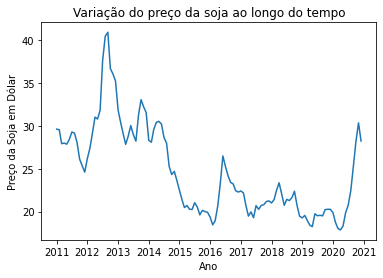

In [69]:
plt.plot('Data', 'Preco_Dolar', data=df)
plt.title('Variação do preço da soja ao longo do tempo')
plt.xlabel('Ano')
plt.ylabel('Preço da Soja em Dólar')
plt.show()

Vamos utilizar o Prophet para a análise de séries temporais. Abaixo descrição da própria página do Facebook Prophet https://facebook.github.io/prophet/docs/quick_start.html

**Facebook Prophet**

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is open source software released by Facebook's Core Data Science team. 

**Importação do Prophet**

In [ ]:
from fbprophet import Prophet

O prophet trabalha com duas colunas:

*   ds: features temporais
*   y: valores a serem preditos

Então vamos renomer nossas colunas para a nomenclatura padrão







In [ ]:
df.columns = ['ds', 'y']

In [ ]:
df.tail()

**Dividir os dados entre treino e teste**

In [ ]:
train = df[df['ds'] < "2020-01-01"]
test = df[df['ds'] >= "2020-01-01"]
train.shape, test.shape

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
test.dtypes

In [ ]:
test.tail(30)

Antes de rodar o modelo Prophet vamos criar uma baseline para servir de comparação dos resultados

**Baseline**

Vamos usar como baseline o preço do período anterior

In [ ]:
# obtem todos od dados do treino 
history = [x for x in train['y']]

# cria lista de previsões
predictions = list()

# aplicando o modelo naive
for i in range(len(test)):
  
  # valor_predito recebe o último valor do conjunto de treino
  valor_predito = history[-1]
  
  # a primeira previsão é o último valor do conjunto de treino
  predictions.append(valor_predito)
  
  # valor real recebe o valor atual do teste.
  valor_real = test['y'].values[i]
  
  # adiciona o valor real para a lista de historico
  history.append(valor_real)
  
  # imprime valor predito e valor real..
  print('Valor Predito=%.3f, Valor Esperado=%.3f' % (valor_predito, valor_real))

**A métrica de erro selecionada foi a RMSLE (root mean squared log error)**

RMSLE incurs a larger penalty for the underestimation of the Actual variable than the Overestimation.Thi is especially useful for business cases where the underestimation of the target variable is not acceptable but overestimation can be tolerated.
In the case of RMSE, the presence of outliers can explode the error term to a very high value. But, in the case of RMLSE the outliers are drastically scaled down therefore nullifying their effect.
RMSLE metric only considers the relative error between and the Predicted and the actual value and the scale of the error is not significant. On the other hand, RMSE value Increases in magnitude if the scale of error increases.


In [ ]:
from pandas import DataFrame

from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(test['y'], DataFrame(predictions,columns=['ypred'])))

Essa métrica pode ser interpretada como 6.63% de erro entre os valores preditos e reais.




Para melhor visualização vamos plotar um gráfico comparando os valores estipulados na baseline com os valores reais do período de teste

In [ ]:
Xtrain, ytrain = train.drop(['y'], axis=1).reset_index(drop=True), train['y'].reset_index(drop=True)
Xtest, ytest = test.drop(['y'], axis=1).reset_index(drop=True), test['y'].reset_index(drop=True)

In [ ]:
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(predictions, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Como podemos observar pelo gráfico e pelo erro, a utilização do valor do período anterior para previsão do próximo período parece ser um bom "chute" inicial. O objetivo agora é criar um modelo que consiga bater essa baseline. Vamos testar o uso do Prophet, procedimento criado pelo Facebook para previsão de time series.

**Primeiro passo é instanciar um objeto Prophet**




In [ ]:
m = Prophet()

**Criar o modelo**

Vamos agora gerar um modelo em cima da nossa base de treino

In [ ]:
m.fit(train)

A partir do modelo treinado podemo prever períodos futuros, sendo o perído definido pelo parâmetro frequência, que utiliza os mesmos padrões de frequência do pandas https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [ ]:
#future = m.make_future_dataframe(periods = 31, freq='B')
future = m.make_future_dataframe(periods = 12, freq='MS')

In [ ]:
future

Como podemos observar o método 'Prophet.make_future_dataframe' cria um dataframe com as datas que queremos fazer as previsões. Agora utilizamos o método 'predict' para calcular e atribuir o valor predito para cada data, assim como seus intervalos de incerteza. 

**Previsões**

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast.head()

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

**Plotar gráficos de forecast e dos componentes**

O método 'plot' plota os dados de forecast, incluindo os dados históricos usados para treino.

In [ ]:
fig1 = m.plot(forecast)

O método 'plot_components' plota os componetes de tendência e sazonalidade (anual, mensal, diária, feriados etc) da time series.

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
len(forecast['yhat'])

# Validando o modelo com Prophet

Aplicando o modelo do prophet à base de teste

In [ ]:
test_forecast = m.predict(test)

Imprimir as saidas

In [ ]:
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

Cálculo do erro (RMSLE)

In [ ]:
from sklearn.metrics import mean_squared_log_error

np.sqrt(mean_squared_log_error(test['y'], test_forecast.yhat))

Esse erro pode ser interpretado como 28.23% de erro entre os valores preditos e os reais.

Vamos plotar o gráfico de comparação

In [ ]:
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(test_forecast.yhat, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

Analisando o erro e o gráfico, podemos concluir que o modelo ficou bem longe de bater a baseline e portanto precisa ser melhorado. Para isso podemos usar diferentes períodos de tempo, verificar se históricamente algum período deveria ser desconsiderado, etc. 

Além disso outra técnicas de modelagem podem ser utilizadas e talvez se adequem melhor a essa série temporal, como as técnicas mais clássicas ARIMA, SARIMA, além de outras técnicas como Random Forest, LightGBM, Redes Neurais entre outras.

**Alterando o período de treino**

Reduzindo o período de treino para apenas 1 ano anterior ao período de teste

In [ ]:
# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_mensal.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

# Definir o perído de treino
df = df[(df['ds'] > "2019-01") & (df['ds'] <= "2020-12")]

# Separar os dados de teste (12 meses)
train = df.drop(df.index[-12:])
print(train.tail(12))

# Instanciar um objeto Prophet
m = Prophet()

# Treinar o modelo
m.fit(train)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2020-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)

# Calcular o erro entre o previsto e o real
ytest = df['y'][-12:].values
ypred = forecast['yhat'].values
rmsle = np.sqrt(mean_squared_log_error(ytest, ypred))
print('RMSLE: %.3f' % rmsle)

# Plotar o gráfico comparativo entre os valores reais e previstos
fig, ax = pylab.subplots(1,1, figsize=(12,7))
ax.plot(ytest, label = 'Y')
axt = ax.twinx()
axt.plot(ypred, color = 'orange', alpha = 0.7, label='Previsões')
axt.set(title='Comparação dos preços previsto e real na base teste',
        ylabel='Preço da Soja em Dólar')
axt.legend()

O erro ficou em 16.1%, ainda bem longe da baseline. Além disso pelo gráfico podemos verificar que a previsão foi bem ruim na maioria dos meses. O que era de se esperar pois analiasando a série histórica, podemos ver que o comportamento do ano 2019 foi bem diferente do ano 2020.

# Criar um "Out-of-Sample Forecast"

**Previsão do preço da soja para o ano de 2021**

Utilizei como treino o ano anterior (2020), supondo que 2021 siga a mesma tendência, porém como pudemos observar essa série temporal não parece seguir tendências e sazonalidades claras, outros fatores como mercado, crises e acordos comercias parecem ter um grande impacto e não conseguem ser modelados por essa abordagem do Prophet. Teríamos que escolher uma abordagem multivariada, provavelmente modelos de árvore e redes neurais possam explicar melhor esses fatores.



In [ ]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot

# Carregar a base
df= pd.read_csv('/content/drive/MyDrive/DGH/preco_soja_diario.csv', sep=";", decimal=",", header=0, encoding='UTF-8')

# Trocar os nomes das colunas para o padrão do Prophet
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

# Definir o período de treino
df = df[df['ds'] > "2020-01-01"]

# # Instanciar um objeto Prophet
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Treinar o modelo
m.fit(df)

# Definir o período que queremos fazer as previsões
future = list()
for i in range(1, 13):
	date = '2021-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

# Realizar as previsões
forecast = m.predict(future)

# Resumo do forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

# Plotar o forecast e os componentes
fig3 = m.plot(forecast)
fig4 = m.plot_components(forecast)